# Tarea 3

Usamos un dataset pequeñito de analisis de sentimiento en tweets. Cada tweet viene con una etiqueta entre `positive`, `negative` y `neutral`.

**Vamos a ver como usar:**
* Utilizar una representacion de word embedding ya entrenada
* Utilizar estes representaciones con MLP y un RNN
* Comparar con un RNN que va apprende su capa de embeddings
* Utilizar un modelo pre-entrenado contextual como BERT

## Se puede utilizar LLM para ayudarse!
Mirar a [un ejemplo](https://chatgpt.com/share/d534833e-bd2c-40c1-81eb-34818b195cac) de como pedir las respuestas a un LLM. Mejor si entenden lo que hagan.

#### Para cada entrenamiento
* Informa de las curvas de pérdida y precisión en el entrenamiento y la validación.
* Detén el entrenamiento en función de los resultados obtenidos en el conjunto de validación.
* Utiliza una tasa de aprendizaje pequeña para que puedas ver cómo disminuye la pérdida en las distintas curvas.  

### Before Starting! Some tips on GPU and Google Colab

You will likely to run this code on Google Colab in order to use GPU ressources. If not, the code will take 60 times more to run!!  

#### Stop disconnection

Colab will disconnect you if you the training is too long. In order to prevent this, you can use this piece of code in the console of your browser:

```java
function ClickConnect(){
console.log("Working");
document.querySelector("colab-toolbar-button#connect").click()
}
setInterval(ClickConnect,60000)
```

See more [here](https://www.reddit.com/r/StableDiffusion/comments/xhhlp0/automatic1111_on_colab_how_to_keep_it_running/).

#### Other account

If you run out of available ressources, what you can do is changing of the account you are using in colab. You can create another gmail and switch to it, this should give you more GPU ressources.

Have fun!

In [1]:
! wget https://users.dcc.uchile.cl/~vbarrier/MModal_Sentiment/Texts.zip
! unzip Texts.zip

'wget' is not recognized as an internal or external command,
operable program or batch file.
'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
import pandas as pd

def read_data(fn):
    df = pd.read_csv(fn, sep='\t')[['tweet', 'label']]
    X = df.tweet
    y = df.label
    return X, y

split='train'
X_train, y_train = read_data('MModal_Sentiment_%s.tsv'%split)
split='dev'
X_dev, y_dev = read_data('MModal_Sentiment_%s.tsv'%split)
split='test'
X_test, y_test = read_data('MModal_Sentiment_%s.tsv'%split)

## Word2vec

Construir una funcion que va a representar un texto. Utilizamos `'glove-twitter-25'` porque es el mas pequeño. Pueden probar con otros modelos mas grandes!

In [3]:
import gensim.downloader
print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [4]:
wv_string = 'glove-twitter-25'
# wv_string = 'glove-twitter-200'
#wv_string = 'word2vec-google-news-300'
wv = gensim.downloader.load(wv_string)

Visualizamos el vector de la palabra *computer*, y cuales son las palabras de los vectores los mas similares en el espacio utilizando la distancia cosinus

In [5]:
wv['computer'], wv.most_similar('computer')

(array([ 0.64005 , -0.019514,  0.70148 , -0.66123 ,  1.1723  , -0.58859 ,
         0.25917 , -0.81541 ,  1.1708  ,  1.1413  , -0.15405 , -0.11369 ,
        -3.8414  , -0.87233 ,  0.47489 ,  1.1541  ,  0.97678 ,  1.1107  ,
        -0.14572 , -0.52013 , -0.52234 , -0.92349 ,  0.34651 ,  0.061939,
        -0.57375 ], dtype=float32),
 [('camera', 0.907833456993103),
  ('cell', 0.891890287399292),
  ('server', 0.874466598033905),
  ('device', 0.8693524599075317),
  ('wifi', 0.863125741481781),
  ('screen', 0.8621907234191895),
  ('app', 0.8615543246269226),
  ('case', 0.8587921857833862),
  ('remote', 0.8583616018295288),
  ('file', 0.8575270771980286)])

### Transform the docs into sequences of embeddings

We take the word-vectors of each of the words in the sentence, so for each sentence we get a sequence of vectors

In [6]:
vocabulary = wv.index_to_key

def from_wd_to_vec(documents):
    documents_wvs = [
        [wv[word] for word in document.lower().split() if word in vocabulary]
        for document in documents
    ]
    return documents_wvs

In [7]:
# TODO: Create the representations
X_train_wvs = from_wd_to_vec(X_train)
X_dev_wvs = from_wd_to_vec(X_dev)
X_test_wvs = from_wd_to_vec(X_test)

#### Visualizacion

Visualiza los vectores en 2D con sus labeles. Usa T-SNE o UMAP

* Para tener un unico vector representando una frase, se puede aggergar los vectores de cada palabra tomando en promedio de los vectores

Por ejemplo utilizando:
```python
documents_wv = [np.mean(list_wv_sent, axis=0) for list_wv_sent in documents_wvs]
```

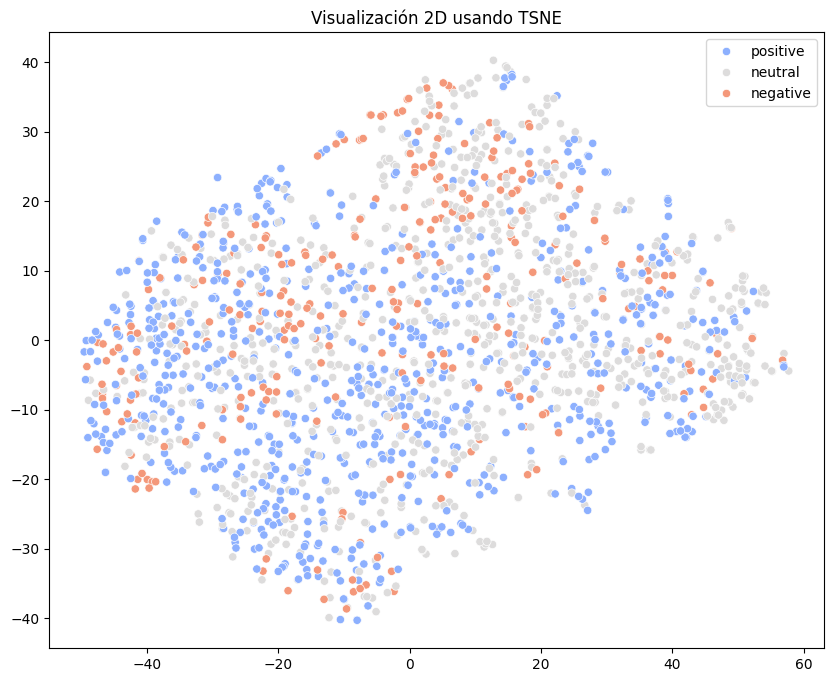

In [21]:
# TODO: Visualization
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

def aggregate_vectors(documents_wvs):
    documents_wv = []
    for list_wv_sent in documents_wvs:
        if len(list_wv_sent) > 0: 
            avg_vector = np.mean(list_wv_sent, axis=0)
            documents_wv.append(avg_vector)
    return np.array(documents_wv)

X_train_agg = aggregate_vectors(X_train_wvs)
y_train_agg = y_train.iloc[:len(X_train_agg)].values  

def visualize_vectors(vectors, labels, ):
    reducer = TSNE(n_components=2, random_state=42)
    vectors_2d = reducer.fit_transform(vectors)
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x=vectors_2d[:, 0], y=vectors_2d[:, 1], hue=labels, palette='coolwarm', legend='full')
    plt.title(f"Visualización 2D usando TSNE")
    plt.show()

visualize_vectors(X_train_agg, y_train_agg)

## Modelizacion

**Metricas**: Para este tarea de clasificacion pueden utilizar el score F-1 para estimar las performancias de los modelos  

### Multi-Layer Perceptron

El MLP solo toma un vector en entrada, no una secuencia de vectores, por eso tenemos que agregar los vectores de las palabras de una sentencia en uno.  

* Aggreg the word vectors of each doc to get one vector per doc
* Learn a MLP

In [22]:
documents_wv_aggreg = [np.mean(document, axis=1) for document in X_train_wvs]

Epoch [1/50], Train Loss: 1.0022, Train Acc: 0.4899, Dev Loss: 0.9320, Dev Acc: 0.5677
Epoch [2/50], Train Loss: 0.9308, Train Acc: 0.5651, Dev Loss: 0.8803, Dev Acc: 0.5785
Epoch [3/50], Train Loss: 0.8789, Train Acc: 0.5794, Dev Loss: 0.8632, Dev Acc: 0.5816
Epoch [4/50], Train Loss: 0.8465, Train Acc: 0.5927, Dev Loss: 0.8326, Dev Acc: 0.5988
Epoch [5/50], Train Loss: 0.8296, Train Acc: 0.6112, Dev Loss: 0.8195, Dev Acc: 0.6096
Epoch [6/50], Train Loss: 0.8207, Train Acc: 0.6107, Dev Loss: 0.8051, Dev Acc: 0.6252
Epoch [7/50], Train Loss: 0.8131, Train Acc: 0.6123, Dev Loss: 0.8027, Dev Acc: 0.6190
Epoch [8/50], Train Loss: 0.8040, Train Acc: 0.6250, Dev Loss: 0.7934, Dev Acc: 0.6330
Epoch [9/50], Train Loss: 0.7984, Train Acc: 0.6224, Dev Loss: 0.7949, Dev Acc: 0.6314
Epoch [10/50], Train Loss: 0.7969, Train Acc: 0.6266, Dev Loss: 0.7872, Dev Acc: 0.6361
Epoch [11/50], Train Loss: 0.7947, Train Acc: 0.6319, Dev Loss: 0.7835, Dev Acc: 0.6205
Epoch [12/50], Train Loss: 0.7907, Train 

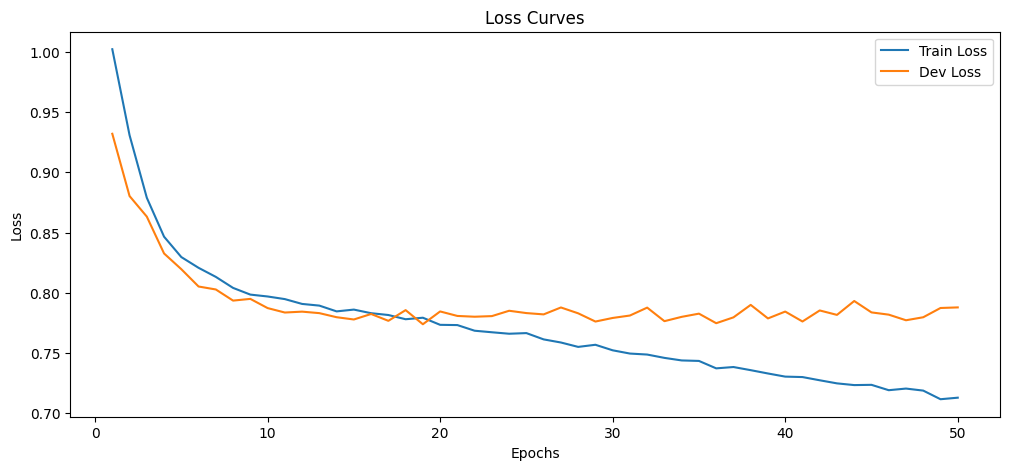

In [23]:
# TODO: MLP
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from torch.utils.data import DataLoader, TensorDataset

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x


def aggregate_word_vectors(documents_wvs):
    return np.array([
        np.mean(doc, axis=0) if len(doc) > 0 else np.zeros(wv.vector_size)
        for doc in documents_wvs
    ])


X_train_agg = aggregate_word_vectors(X_train_wvs)
X_dev_agg = aggregate_word_vectors(X_dev_wvs)
X_test_agg = aggregate_word_vectors(X_test_wvs)


label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_dev_encoded = label_encoder.transform(y_dev)

X_train_tensor = torch.FloatTensor(X_train_agg)
y_train_tensor = torch.LongTensor(y_train_encoded)
X_dev_tensor = torch.FloatTensor(X_dev_agg)
y_dev_tensor = torch.LongTensor(y_dev_encoded)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
dev_dataset = TensorDataset(X_dev_tensor, y_dev_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=32, shuffle=False)

input_size = X_train_agg.shape[1]
hidden_size = 100
output_size = len(set(y_train_encoded))
model = MLP(input_size, hidden_size, output_size)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


num_epochs = 50
train_loss_history = []
dev_loss_history = []
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    total_train_correct = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        total_train_loss += loss.item()

        _, preds = torch.max(outputs, dim=1)
        total_train_correct += torch.sum(preds == labels)

        loss.backward()
        optimizer.step()

    avg_train_loss = total_train_loss / len(train_loader)
    avg_train_accuracy = total_train_correct.double() / len(train_loader.dataset)

    model.eval()
    total_dev_loss = 0
    total_dev_correct = 0

    with torch.no_grad():
        for inputs, labels in dev_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_dev_loss += loss.item()

            _, preds = torch.max(outputs, dim=1)
            total_dev_correct += torch.sum(preds == labels)

    avg_dev_loss = total_dev_loss / len(dev_loader)
    avg_dev_accuracy = total_dev_correct.double() / len(dev_loader.dataset)

    train_loss_history.append(avg_train_loss)
    dev_loss_history.append(avg_dev_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, '
          f'Train Acc: {avg_train_accuracy:.4f}, Dev Loss: {avg_dev_loss:.4f}, Dev Acc: {avg_dev_accuracy:.4f}')




model.eval()
with torch.no_grad():
    X_dev_tensor = X_dev_tensor.to(device)
    y_dev_pred = model(X_dev_tensor)
    y_dev_pred_classes = torch.argmax(y_dev_pred, axis=1).cpu().numpy()

f1 = f1_score(y_dev_encoded, y_dev_pred_classes, average='weighted')
precision = precision_score(y_dev_encoded, y_dev_pred_classes, average='weighted')
recall = recall_score(y_dev_encoded, y_dev_pred_classes, average='weighted')
print(f"F1 Score (Validation Set): {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")


with torch.no_grad():
    X_train_tensor = X_train_tensor.to(device)
    y_train_pred = model(X_train_tensor)
    y_train_pred_classes = torch.argmax(y_train_pred, axis=1).cpu().numpy()

f1_test = f1_score(label_encoder.transform(y_train), y_train_pred_classes, average='weighted')
precision_test = precision_score(label_encoder.transform(y_train), y_train_pred_classes, average='weighted')
recall_test = recall_score(label_encoder.transform(y_train), y_train_pred_classes, average='weighted')
print(f"F1 Score (Train Set): {f1_test:.4f}, Precision: {precision_test:.4f}, Recall: {recall_test:.4f}")


plt.figure(figsize=(12, 5))
plt.plot(range(1, num_epochs+1), train_loss_history, label='Train Loss')
plt.plot(range(1, num_epochs+1), dev_loss_history, label='Dev Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()
plt.show()

### RNN-LSTM

Use the sequences of wordvectors using a Recurrent Neural Network

c:\Users\Daniel\Documents\GitHub\Deep-Learning\venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


Epoch [1/50], Train Loss: 1.0458, Train Acc: 0.4423, Dev Loss: 0.9933, Dev Acc: 0.4883
Epoch [2/50], Train Loss: 1.0148, Train Acc: 0.4539, Dev Loss: 0.9809, Dev Acc: 0.4883
Epoch [3/50], Train Loss: 1.0165, Train Acc: 0.4539, Dev Loss: 0.9868, Dev Acc: 0.4883
Epoch [4/50], Train Loss: 1.0171, Train Acc: 0.4539, Dev Loss: 0.9804, Dev Acc: 0.4883
Epoch [5/50], Train Loss: 1.0158, Train Acc: 0.4539, Dev Loss: 0.9790, Dev Acc: 0.4883
Epoch [6/50], Train Loss: 1.0184, Train Acc: 0.4539, Dev Loss: 0.9827, Dev Acc: 0.4883
Epoch [7/50], Train Loss: 1.0056, Train Acc: 0.4523, Dev Loss: 0.9807, Dev Acc: 0.4868
Epoch [8/50], Train Loss: 0.9759, Train Acc: 0.4640, Dev Loss: 0.9376, Dev Acc: 0.4837
Epoch [9/50], Train Loss: 0.9568, Train Acc: 0.4476, Dev Loss: 0.9211, Dev Acc: 0.4899
Epoch [10/50], Train Loss: 0.9534, Train Acc: 0.4682, Dev Loss: 0.9189, Dev Acc: 0.5086
Epoch [11/50], Train Loss: 0.9380, Train Acc: 0.4645, Dev Loss: 0.9020, Dev Acc: 0.5443
Epoch [12/50], Train Loss: 0.9246, Train 

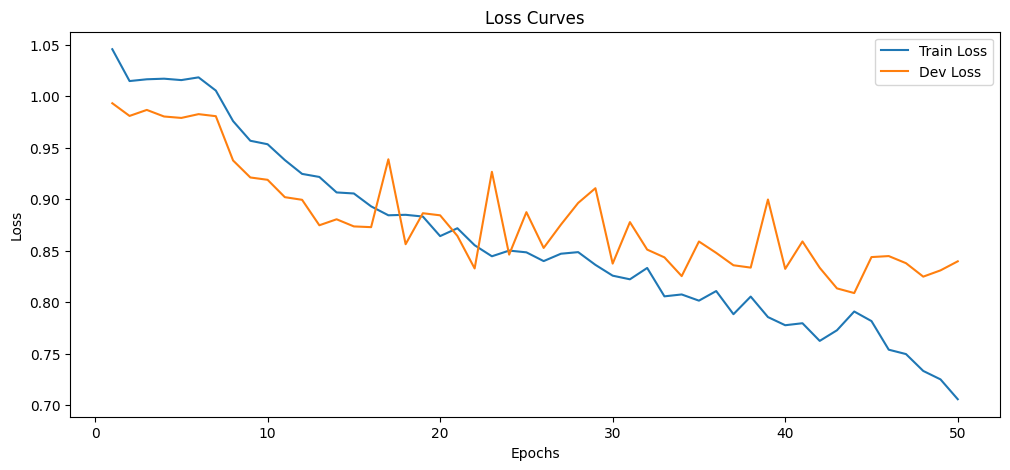

In [24]:
# TODO: RNN-LSTM
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_prob=0.5):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True, dropout=dropout_prob)
        self.fc = nn.Linear(hidden_size, output_size)
        self.init_weights()

    def init_weights(self):
        for name, param in self.named_parameters():
            if 'weight' in name:
                nn.init.xavier_uniform_(param)
            elif 'bias' in name:
                nn.init.zeros_(param)

    def forward(self, x):
        out, (h_n, c_n) = self.lstm(x)
        out = self.fc(h_n[-1])
        return out


def prepare_sequences(documents_wvs, seq_length, vector_size):
    sequences = []
    for doc in documents_wvs:
        if len(doc) > 0:
            if len(doc) >= seq_length:
                sequences.append(doc[:seq_length])
            else:
                padding = np.zeros((seq_length - len(doc), vector_size))
                sequences.append(np.vstack((doc, padding)))
        else:
            sequences.append(np.zeros((seq_length, vector_size)))
    return np.array(sequences)


seq_length = 50
vector_size = wv.vector_size

X_train_seq = prepare_sequences(X_train_wvs, seq_length, vector_size)
X_dev_seq = prepare_sequences(X_dev_wvs, seq_length, vector_size)
X_test_seq = prepare_sequences(X_test_wvs, seq_length, vector_size)

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_dev_encoded = label_encoder.transform(y_dev)

X_train_tensor = torch.FloatTensor(X_train_seq)
y_train_tensor = torch.LongTensor(y_train_encoded)
X_dev_tensor = torch.FloatTensor(X_dev_seq)
y_dev_tensor = torch.LongTensor(y_dev_encoded)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
dev_dataset = TensorDataset(X_dev_tensor, y_dev_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=32, shuffle=False)

input_size = wv.vector_size
hidden_size = 100
output_size = len(set(y_train_encoded))
model = LSTMModel(input_size, hidden_size, output_size)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

num_epochs = 50
train_loss_history = []
dev_loss_history = []
train_accuracy_history = []
dev_accuracy_history = []
epochs = []
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    total_train_correct = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        total_train_loss += loss.item()

        _, preds = torch.max(outputs, dim=1)
        total_train_correct += torch.sum(preds == labels)

        loss.backward()
        optimizer.step()

    avg_train_loss = total_train_loss / len(train_loader)
    avg_train_accuracy = total_train_correct.double() / len(train_loader.dataset)

    model.eval()
    total_dev_loss = 0
    total_dev_correct = 0

    with torch.no_grad():
        for inputs, labels in dev_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_dev_loss += loss.item()

            _, preds = torch.max(outputs, dim=1)
            total_dev_correct += torch.sum(preds == labels)

    avg_dev_loss = total_dev_loss / len(dev_loader)
    avg_dev_accuracy = total_dev_correct.double() / len(dev_loader.dataset)

    train_loss_history.append(avg_train_loss)
    dev_loss_history.append(avg_dev_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, '
          f'Train Acc: {avg_train_accuracy:.4f}, Dev Loss: {avg_dev_loss:.4f}, Dev Acc: {avg_dev_accuracy:.4f}')



model.eval()
with torch.no_grad():
    X_dev_tensor = X_dev_tensor.to(device)
    y_dev_pred = model(X_dev_tensor)
    y_dev_pred_classes = torch.argmax(y_dev_pred, axis=1).cpu().numpy()

f1 = f1_score(y_dev_encoded, y_dev_pred_classes, average='weighted')
precision = precision_score(y_dev_encoded, y_dev_pred_classes, average='weighted')
recall = recall_score(y_dev_encoded, y_dev_pred_classes, average='weighted')
print(f"F1 Score (Validation Set): {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")



with torch.no_grad():
    X_train_tensor = X_train_tensor.to(device)
    y_train_pred = model(X_train_tensor)
    y_train_pred_classes = torch.argmax(y_train_pred, axis=1).cpu().numpy()

f1_test = f1_score(label_encoder.transform(y_train), y_train_pred_classes, average='weighted')
precision_test = precision_score(label_encoder.transform(y_train), y_train_pred_classes, average='weighted')
recall_test = recall_score(label_encoder.transform(y_train), y_train_pred_classes, average='weighted')
print(F"F1 Score (Train Set): {f1_test:.4f}, Precision: {precision_test:.4f}, Recall: {recall_test:.4f}")


plt.figure(figsize=(12, 5))
plt.plot(range(1, num_epochs+1), train_loss_history, label='Train Loss')
plt.plot(range(1, num_epochs+1), dev_loss_history, label='Dev Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()
plt.show()

### Preguntas

* Cuál es la ventaja de la modelización con RNN sobre MLP al usar una agregación de word embeddings?
* Cuál es el beneficio de inicializar el RNN con los word embeddings de Word2Vec?
* Como se comparan los entrenamientos de los diferentes modelos?
* Como se comparan los resultados de los diferentes modelos?
* Que podemos ver con modelos de embedding mas grandes (complejos)?

### Respuestas

* La principal ventaja de usar redes neuronales recurrentes (RNN) sobre las redes neuronales multicapa (MLP) es que las RNN están diseñadas para procesar secuencias de datos, manteniendo un estado oculto que permite recordar información previa. Esto es crucial en tareas de procesamiento de lenguaje natural, donde el significado de una oración depende del orden de las palabras. Las MLP, en contraste, tratan las entradas de manera independiente, sin tener en cuenta la posición relativa de las palabras.

* El beneficio de inicializar un RNN con los embeddings preentrenados de Word2Vec es que se parte de una representación de palabras que ya captura relaciones semánticas, lo que mejora la calidad inicial del modelo. Esto también acelera el proceso de entrenamiento, ya que el modelo no necesita aprender las representaciones de las palabras desde cero. Esta estrategia es particularmente útil cuando se trabaja con conjuntos de datos pequeños o con palabras que no ocurren frecuentemente.

* En este caso, se observó una diferencia significativa en el tiempo de entrenamiento entre los modelos: 7 segundos para el MLP frente a 15 segundos para el RNN. Aunque el RNN tarda aproximadamente el doble, ambos entrenamientos fueron rápidos debido al pequeño tamaño del dataset y al uso de GPU. No obstante, ambos modelos mostraron signos de sobreajuste al superar las 20 épocas, lo que se reflejó en un aumento en la pérdida del conjunto de validación. Este sobreajuste ocurre porque los modelos aprenden en exceso los patrones específicos del conjunto de entrenamiento, lo que reduce su capacidad para generalizar correctamente en nuevos datos.

* Los resultados de los modelos MLP y RNN fueron más similares de lo esperado, con una precisión del 65% y 65% respectivamente en el conjunto de validación. Ambos modelos experimentaron sobreajuste tras un número determinado de épocas. Aunque la pérdida en el conjunto de entrenamiento siguió disminuyendo, la pérdida en el conjunto de validación se estabilizó o incluso aumentó, lo que indica sobreajuste. Este comportamiento podría deberse a que, para este dataset en particular, tanto el MLP como el RNN capturan características similares, y el tamaño reducido del dataset no permite aprovechar plenamente la capacidad de modelado secuencial de las RNN.

* Generalmente, se espera que los modelos más grandes y complejos, con más parámetros, sean capaces de capturar representaciones más ricas y mejorar el rendimiento. Sin embargo, en este caso, los modelos más grandes de embeddings no ofrecieron mejoras, e incluso produjeron peores resultados. Esto puede deberse a que el dataset es relativamente pequeño, lo que hace que los modelos más grandes tiendan a sobreajustarse. En cambio, los modelos más simples lograron generalizar mejor, evitando el sobreajuste.


## BERT

Use a pre-trained BERT from the HuggingFace library and fine-tune it on the dataset.

* For the data, you can use the classes `Dataset` and `DataLoader` from `torch.utils.data`
* For the modelization:
  * You can use the classes `BertTokenizer` and `BertForSequenceClassification` from the `transformers` library
  * Load the weights of the models already pre-trained, with the associated tokenizer!
  * You can use a [classical bert](https://huggingface.co/bert-base-uncased) `'bert-base-uncased'`  
  * You can also use another model from huggingface, like [a smaller model](https://huggingface.co/distilbert-base-uncased) such as `distilbert-base-uncased` (it is an example)
* For the fine-tuning (optimization):
    * Make the loop in pytorch, **do not use** the class `Trainer` from the `transformers` library
    * You can use classical loss functions like cross-entropy and the optimizer you want, `Adam` or `AdamW` for example.
    * Reports the loss and accuracy curves on the train and validation
    * Stop the training regarding the performances obtained on the validation set
    * Use a small learning rate so you can see the loss going down on the different curves  

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/5], Train Loss: 1.0142, Train Acc: 0.4793, Dev Loss: 0.9106, Dev Acc: 0.5677
Epoch [2/5], Train Loss: 0.7799, Train Acc: 0.6695, Dev Loss: 0.8186, Dev Acc: 0.6594
Epoch [3/5], Train Loss: 0.5792, Train Acc: 0.7707, Dev Loss: 0.6854, Dev Acc: 0.7138
Epoch [4/5], Train Loss: 0.3825, Train Acc: 0.8655, Dev Loss: 0.7236, Dev Acc: 0.7449
Epoch [5/5], Train Loss: 0.2413, Train Acc: 0.9274, Dev Loss: 0.8629, Dev Acc: 0.7403
F1 Score (Train Set): 0.9734, Precision: 0.9737, Recall: 0.9735
F1 Score (Validation Set): 0.7389, Precision: 0.7475, Recall: 0.7403


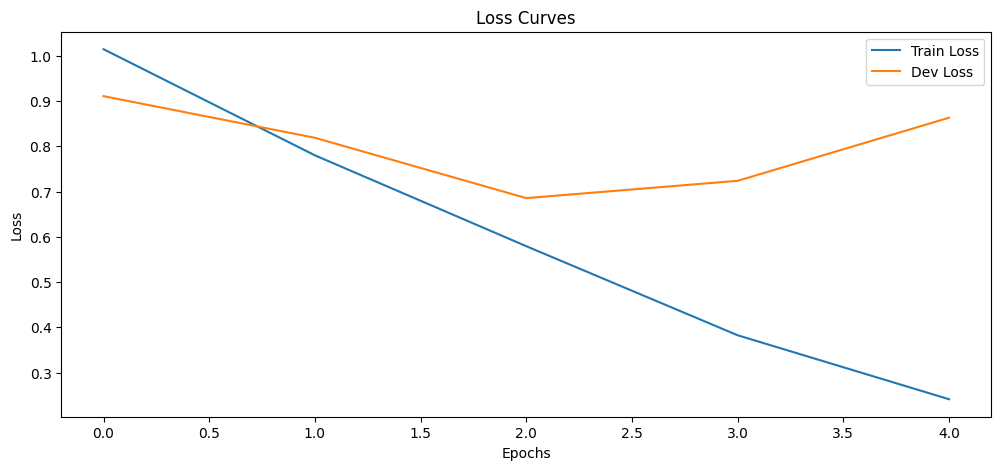

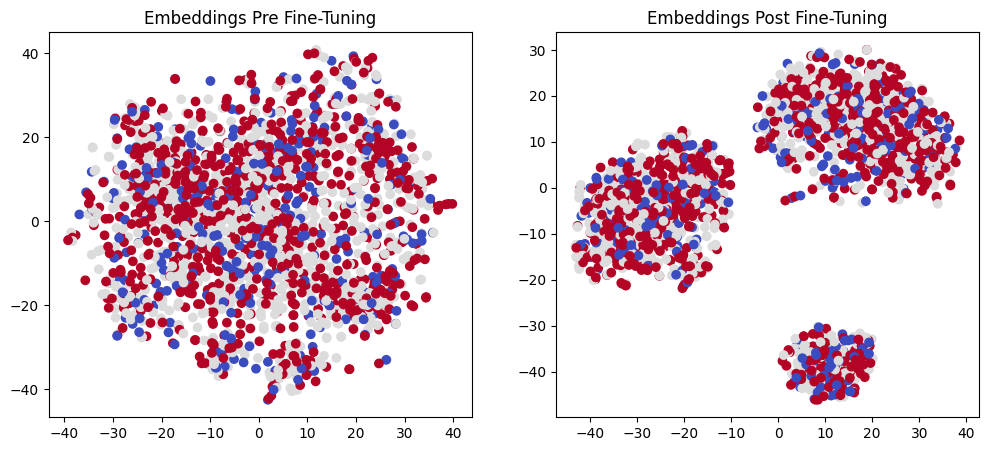

In [13]:
# TODO: BERT
import numpy as np
import pandas as pd
import torch
from sklearn.manifold import TSNE
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import AdamW
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(set(y_train)), output_hidden_states=True)



max_len = 128
train_dataset = TextDataset(X_train.tolist(), y_train_encoded.tolist(), tokenizer, max_len)
dev_dataset = TextDataset(X_dev.tolist(), y_dev_encoded.tolist(), tokenizer, max_len)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=32, shuffle=False)

optimizer = AdamW(model.parameters(), lr=2e-5)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

#embedings pre fine-tuning
model.eval()
cls_embeddings_pre_finetuning = []
with torch.no_grad():
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        hidden_states = outputs.hidden_states 
        cls_embeddings_pre_finetuning.append(hidden_states[-1][:, 0, :].cpu().numpy())

cls_embeddings_pre_finetuning = np.vstack(cls_embeddings_pre_finetuning)

train_loss_history = []
dev_loss_history = []
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    total_train_correct = 0

    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_train_loss += loss.item()

        _, preds = torch.max(outputs.logits, dim=1)
        total_train_correct += torch.sum(preds == labels)

        loss.backward()
        optimizer.step()

    avg_train_loss = total_train_loss / len(train_loader)
    avg_train_accuracy = total_train_correct.double() / len(train_loader.dataset)

    model.eval()
    total_dev_loss = 0
    total_dev_correct = 0

    with torch.no_grad():
        for batch in dev_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_dev_loss += loss.item()

            _, preds = torch.max(outputs.logits, dim=1)
            total_dev_correct += torch.sum(preds == labels)

    avg_dev_loss = total_dev_loss / len(dev_loader)
    avg_dev_accuracy = total_dev_correct.double() / len(dev_loader.dataset)

    train_loss_history.append(avg_train_loss)
    dev_loss_history.append(avg_dev_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_accuracy:.4f}, '
          f'Dev Loss: {avg_dev_loss:.4f}, Dev Acc: {avg_dev_accuracy:.4f}')


model.eval()
with torch.no_grad():
    all_preds = []
    all_labels = []
    for batch  in train_loader:
        inputs = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids=inputs, attention_mask=attention_mask)
        logits = outputs.logits
        _, preds = torch.max(logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

f1 = f1_score(all_labels, all_preds, average='weighted')
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
print(f"F1 Score (Train Set): {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

with torch.no_grad():
  all_preds_test = []
  all_labels_test = []
  for batch in dev_loader:
      inputs = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      labels = batch['labels'].to(device)
      outputs = model(input_ids=inputs, attention_mask=attention_mask)
      logits = outputs.logits
      _, preds = torch.max(logits, dim=1)
      all_preds_test.extend(preds.cpu().numpy())
      all_labels_test.extend(labels.cpu().numpy())

f1_test = f1_score(all_labels_test, all_preds_test, average='weighted')
precision_test = precision_score(all_labels_test, all_preds_test, average='weighted')
recall_test = recall_score(all_labels_test, all_preds_test, average='weighted')
print(F"F1 Score (Validation Set): {f1_test:.4f}, Precision: {precision_test:.4f}, Recall: {recall_test:.4f}")

plt.figure(figsize=(12, 5))
plt.plot(train_loss_history, label='Train Loss')
plt.plot(dev_loss_history, label='Dev Loss')
plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#embedings post fine-tuning
model.eval()
cls_embeddings_post_finetuning = []
with torch.no_grad():
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        hidden_states = outputs.hidden_states
        cls_embeddings_post_finetuning.append(hidden_states[-1][:, 0, :].cpu().numpy())
cls_embeddings_post_finetuning = np.vstack(cls_embeddings_post_finetuning)

reducer = TSNE(n_components=2, random_state=42)
cls_embeddings_pre_finetuning_2d = reducer.fit_transform(cls_embeddings_pre_finetuning)
cls_embeddings_post_finetuning_2d = reducer.fit_transform(cls_embeddings_post_finetuning)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(cls_embeddings_pre_finetuning_2d[:, 0], cls_embeddings_pre_finetuning_2d[:, 1], c=y_train_encoded, cmap='coolwarm')
plt.title('Embeddings Pre Fine-Tuning')
plt.subplot(1, 2, 2)
plt.scatter(cls_embeddings_post_finetuning_2d[:, 0], cls_embeddings_post_finetuning_2d[:, 1], c=y_train_encoded, cmap='coolwarm')
plt.title('Embeddings Post Fine-Tuning')
plt.show()

### Preguntas

* Haz una hipótesis sobre por qué los resultados de BERT son mejores que los de otros modelos.
* Cuál es la principal limitación de Word2Vec en comparación con BERT a nivel lingüístico al representar palabras? Propón un ejemplo.
* Visualiza los vectores del token `[CLS]` de BERT después del fine-tuning. Qué diferencias notas en comparación con antes?
* Qué sucede si utilizas un modelo diferente, como RoBERTa?

#### Respuestas

* Una posible hipótesis de por qué BERT supera a otros modelos es que utiliza un mecanismo de atención bidireccional que le permite considerar tanto las palabras anteriores como las posteriores en una oración, capturando de forma más precisa las relaciones contextuales y semánticas. A diferencia de los modelos MLP, que no manejan secuencias, y los RNN, que solo ven el contexto pasado y tienden a tener problemas con dependencias a largo plazo, BERT puede modelar dependencias a cualquier distancia dentro de una oración.

* La principal limitación de Word2Vec es que genera representaciones estáticas de las palabras, lo que significa que cada palabra tiene un único vector de representación, independientemente del contexto en el que aparece. Esto genera problemas para palabras, como 'banco', que tiene múltiples significados (una institución financiera o un lugar para sentarse). Word2Vec no puede diferenciar estos significados, ya que asigna el mismo vector a ambos. En cambio, BERT genera representaciones dinámicas, ajustando el vector de la palabra 'banco' en función del contexto de la oración, lo que permite una mejor desambiguación de significados.

* Al visualizar los vectores [CLS] de BERT antes y después del fine-tuning, se puede notar que, después del fine-tuning, los vectores muestran una mayor agrupación, lo que indica que el modelo ha ajustado las representaciones para reflejar mejor las características relevantes para la tarea de clasificación. Sin embargo, es notable que dentro de cada clúster todavía se observan ejemplos de diferentes clases, lo que sugiere que el modelo no ha logrado una separación perfecta entre las clases. Antes del fine-tuning, los vectores de las oraciones estaban distribuidos de manera más dispersa y no había una estructura clara, lo que indica que las representaciones eran más generales. El fine-tuning permite que el modelo capture características más específicas, aunque la mezcla de clases dentro de algunos clústeres sugiere que aún podría haber ambigüedad en algunas muestras o que el modelo no ha alcanzado una separación óptima para todas las clases

* RoBERTa y BERT se basan en la misma arquitectura subyacente, pero RoBERTa incluye varias mejoras, como la eliminación de la tarea de predicción de la siguiente oración y un preentrenamiento en una mayor cantidad de datos. En el experimento, aunque no se observan grandes diferencias en los parámetros entre ambos modelos, RoBERTa obtiene un mejor rendimiento en el conjunto de validación. Esto es coherente con las mejoras introducidas, que permiten a RoBERTa tener una mayor capacidad de generalización y un rendimiento ligeramente superior en comparación con BERT

BERT:

F1 Score (Train Set): 0.9793, Precision: 0.9799, Recall: 0.9793

F1 Score (Validation Set): 0.6659, Precision: 0.7002, Recall: 0.6734


RoBERTa:

F1 Score (Train Set): 0.9683, Precision: 0.9687, Recall: 0.9682

F1 Score (Validation Set): 0.7189, Precision: 0.7250, Recall: 0.7170